# Dataset convertion and inspect

In [10]:
%matplotlib inline
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tips.io import load_ds
from glob import glob
from pathlib import Path
logger = logging.getLogger('tips')
logger.setLevel('INFO')
tf.get_logger().setLevel('INFO')

In [2]:
key2name = {
    'hoac-c1im-a32b32i0-rho1.0753':   '0%-1.08',
    'hoac-c1im-a16b16i16-rho1.0753': '50%-1.08',
    'hoac-c1im-a0b0i32-rho1.0753':  '100%-1.08',
    'hoac-c1im-a32b32i0-rho1.1551':   '0%-1.16',
    'hoac-c1im-a16b16i16-rho1.1551': '50%-1.16',
    'hoac-c1im-a0b0i32-rho1.1551':  '100%-1.16',
}

## To get the PiNN formatted datasets from CP2K logs...

```bash
#!/bin/bash
projs=();for f in nvt-*/*; do projs+=($f/cp2k-md); done; echo ${projs[@]}
tips convert ${projs[@]} -f cp2k -of pinn -o pils-40ps --shuffle
```

In [3]:
inits = set([Path(init).name for init in glob('../trajs/cp2k/nvt-*/*/')])
ds_all = {}
for init in inits:
    projs = [Path(proj)/'cp2k-md' for proj in glob(f'../trajs/cp2k/nvt-*/{init}/')]
    ds_all[init] = load_ds(projs, fmt='cp2k')
    print(init, list(ds_all[init].meta['spec'].keys()))

hoac-c1im-a32b32i0-rho1.1551 ['elem', 'coord', 'force', 'cell', 'energy']
hoac-c1im-a16b16i16-rho1.1551 ['elem', 'coord', 'force', 'cell', 'energy']
hoac-c1im-a0b0i32-rho1.0753 ['elem', 'coord', 'force', 'cell', 'energy']
hoac-c1im-a32b32i0-rho1.0753 ['elem', 'coord', 'force', 'cell', 'energy']
hoac-c1im-a16b16i16-rho1.0753 ['elem', 'coord', 'force', 'cell', 'energy']
hoac-c1im-a0b0i32-rho1.1551 ['elem', 'coord', 'force', 'cell', 'energy']


In [4]:
for init in inits:
    #load_ds(f'../trajs/cp2k/nvt-30-40ps/{init}/cp2k-md', fmt='cp2k')[-1:].convert(init, fmt='extxyz')
    datum = load_ds(f'../trajs/cp2k/nvt-30-40ps/{init}/cp2k-md', fmt='cp2k')[-1]
    print(init, datum['energy']/640, np.abs(datum['force']).max())


hoac-c1im-a32b32i0-rho1.1551 -125.20063044512953 4.2348605511069355
hoac-c1im-a16b16i16-rho1.1551 -125.19964734995729 4.069119162924314
hoac-c1im-a0b0i32-rho1.0753 -125.21989787381638 4.394051637467469
hoac-c1im-a32b32i0-rho1.0753 -125.21581971026419 4.257920348557383
hoac-c1im-a16b16i16-rho1.0753 -125.21827252603813 4.4019095046554675
hoac-c1im-a0b0i32-rho1.1551 -125.20399093449569 3.690855946154835


In [5]:
from ase.io import read
from ase import Atoms, neighborlist
from scipy import sparse
for f in glob('m*.xyz'):
    atoms =read(f)
    (heavy,) = np.where(atoms.numbers != 1)
    (hydro,) = np.where(atoms.numbers == 1)
    natoms = len(atoms)
    heavya2r = lambda x: heavy.tolist().index(x)

    cutoff = {
        ("H", "C"): 2,
        ("H", "N"): 2,
        ("H", "O"): 2,
        ("C", "C"): 2,
        ("C", "N"): 2,
        ("C", "O"): 2,
    }

    # build initial nl, see ase doc [ase/neighborlsit] ===================================
    nl_i, nl_j, nl_d = neighborlist.neighbor_list("ijd", atoms, cutoff, self_interaction=False)
    conMat = sparse.dok_matrix((natoms, natoms), dtype=np.int8)
    conMat[nl_i, nl_j] = 1  # we have several running indices here prefixed by (nl, mol, h)
    conMat[nl_j, nl_i] = 1  # v---- shamelessly taken from the ase documentation
    n_mol, mol_assign = sparse.csgraph.connected_components(conMat[heavy, :][:, heavy])
    symbs = [str(atoms[heavy][mol_assign == mol_i].symbols) for mol_i in range(n_mol)]
    cnt_mol = [symbs.count(k) for k in set(symbs)]
    assert set(symbs) == set(["C2O2", "CNC2NC"]), f"broken molecules: {set(symbs)}"
    type_mol = np.array(["N" in symb for symb in symbs], int)
    print(f)

m32i0-r1.08.xyz
m16i16-r1.16.xyz
m16i16-r1.08.xyz
m0i32-r1.08.xyz
m0i32-r1.16.xyz
m32i0-r1.16.xyz


In [8]:
energy_stat, force_stat, labels = [], [], []

for k in sorted(ds_all.keys()):
    labels.append(key2name[k])
    e_stat, f_stat = [], []
    for datum in ds_all[k].shuffle()[:5000]:
        e_stat.append(datum['energy'])
        f_stat.append(datum['force'].ravel())
    energy_stat.append(np.array(e_stat))
    force_stat.append(np.concatenate(f_stat))

In [15]:
e_stat, f_stat = [], []
for datum in load_ds('../datasets//pils-40ps.yml', fmt='pinn')[:5000]:
    e_stat.append(datum['energy'])
    f_stat.append(datum['force'].ravel())
energy_stat_gen=np.array(e_stat)
force_stat_gen=np.concatenate(f_stat)

Indexing a generator based dataset, this can be slow.


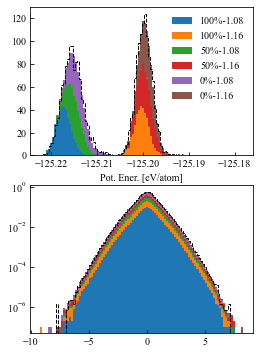

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=[4,6])


ax1.hist([stat/640. for stat in energy_stat], 
         bins=100, stacked=True, label=labels, density=True)

ax1.hist(energy_stat_gen/640., bins=100, color='k', ls='--', histtype='step', fill=False, density=True)
ax2.hist([stat for stat in force_stat], 
         bins=100, stacked=True, label=labels, density=True)
ax2.hist(force_stat_gen, bins=100, color='k', ls='--', histtype='step', fill=False, density=True)

ax1.legend()
ax1.set_xlabel('Pot. Ener. [eV/atom]')
#ax1.set_yscale('log')
ax2.set_yscale('log')